In [19]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import TAPDataset, TAPDataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_all.txt"
# basin_list_file = data_dir / "metadata" / "site_lists" / "sites_ssc_area1000_n10.txt"

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

# basin_list = basin_list[:100]

data_args = {'data_dir': data_dir,
             'basin_list': basin_list,
             'features_dict': {'daily':['grfr_q'],
                               'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
             'static_features':['wet_pc_s02', 'glc_pc_s11', 'dor_pc_pva', 'soc_th_sav', 'snw_pc_s08', 
                                'wet_pc_s09', 'fmh_cl_smj', 'glc_pc_s14', 'pnv_pc_s11', 'pac_pc_sse'],
             'target': 'turbidity',
             'time_slice': slice('1979-01-01', '2018-12-31'),
             'split_time': np.datetime64('2010-01-01'),
             'sequence_length': 30,
             'log_norm_cols': ['turbidity', 'grfr_q'],
             'clip_target_to_zero': True,
             'discharge_col': 'grfr_q'}

dataset = TAPDataset(**data_args)

Loading Basins:   0%|          | 0/1867 [00:00<?, ?it/s]

Output()

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Training finished or interrupted. Model state saved.


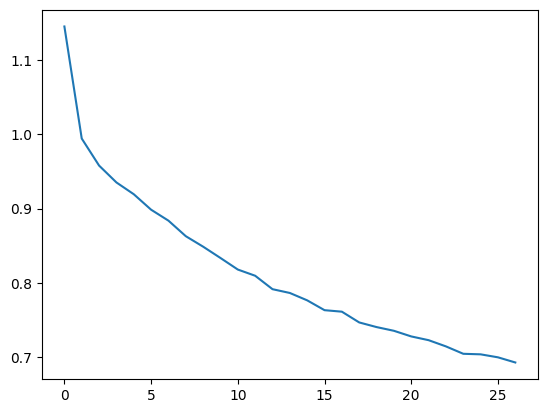

In [21]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import Trainer

model_args = {'daily_in_size': len(data_args['features_dict']['daily']),
              'irregular_in_size': len(data_args['features_dict']['irregular']),
              'static_in_size': dataset.x_s[basin_list[0]].shape[0],
              'out_size': 1,
              'hidden_size': 16,
              'dropout': 0.4,
              'key': jax.random.PRNGKey(0)}
model = TAPLSTM(**model_args)

loader_args = {'suffle': True,
               'batch_size': 64,
               'data_subset': 'pre-train',
               'num_workers': 1,
               'pin_memory': True} 
dataloader = TAPDataLoader(dataset, **loader_args)

num_epochs =  50
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.01, num_epochs, 0.5)
trainer = Trainer(model, dataloader, lr_schedule, num_epochs)
trainer.start_training()


Output()

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Training finished or interrupted. Model state saved.


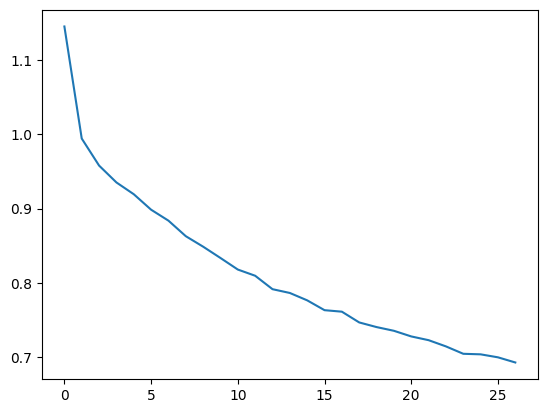

In [22]:
loader_args['data_subset'] = 'train'
trainer.dataloader = TAPDataLoader(dataset, **loader_args)
trainer.num_epochs += 50
# trainer.freeze_components('tealstm_i',True)
trainer.start_training()

In [44]:
from metrics import get_all_metrics

importlib.reload(evaluate)
from evaluate import predict

basin = np.random.choice(basin_list).tolist()

loader_args['data_subset'] = 'test'
loader_args['basin_subset'] =  basin
loader_args['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(dataset, **loader_args)

results = predict(trainer.model, dataloader, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/52 [00:00<?, ?it/s]

{'mse': 5603.306,
 'rmse': 74.85523,
 'kge': 0.03337562352713941,
 'nse': -1.8464324474334717}

In [45]:
results

obs       pred
basin      date                      
7120638920 2013-01-26  NaN  34.037228
           2010-10-10  NaN   4.391417
           2018-10-27  NaN  13.427197
           2017-10-06  NaN   5.369331
           2013-08-18  NaN  34.176437
...                    ...        ...
           2017-01-21  NaN   3.005800
           2014-04-14  NaN   6.775237
           2011-01-27  NaN   3.731597
           2016-09-12  NaN   3.837943
           2015-05-08  NaN   8.731351

[3287 rows x 2 columns]

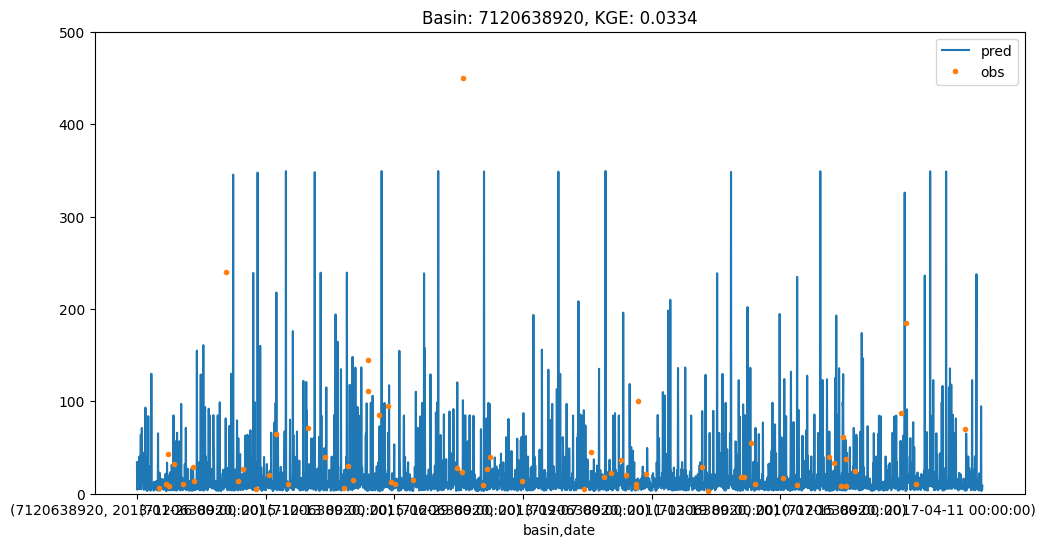

In [46]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

metrics = get_all_metrics(results['obs'],results['pred'])

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.ylim([0,500])
plt.show()

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [30]:
import pickle
data_path = trainer.log_dir / "epoch78_error0_data.pkl"
with open(data_path, 'rb') as f:
    error_data = pickle.load(f)
error_data['batch']['y'][:,-1]

EOFError: Ran out of input